In [2]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec
from step_response import LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "./re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

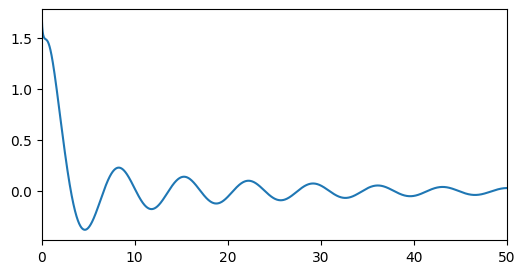

In [3]:
# Load data from model_reduction/step_response.py
step_response = np.load("re100_impulse_output/long_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


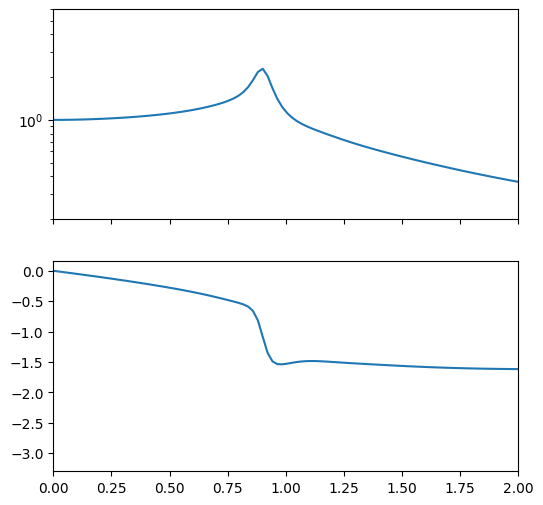

In [4]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
freqs = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [5]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


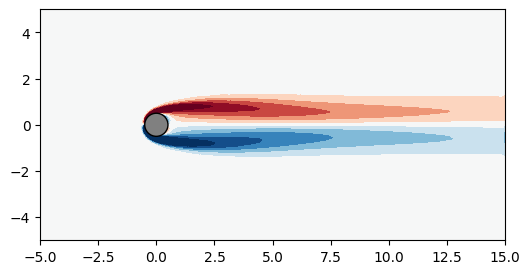

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


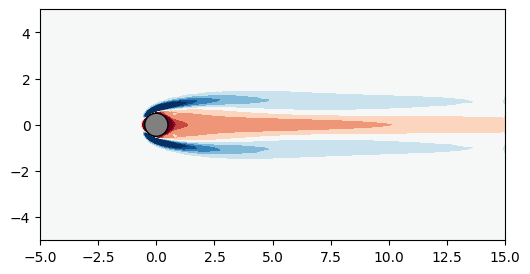

In [7]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

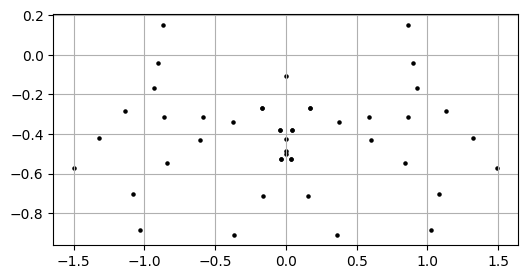

In [8]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

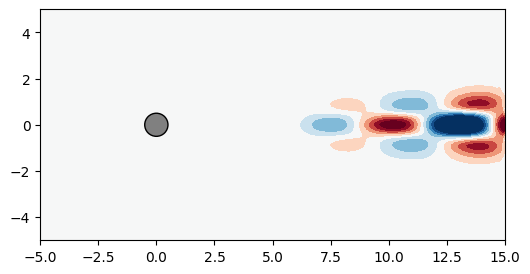

In [9]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

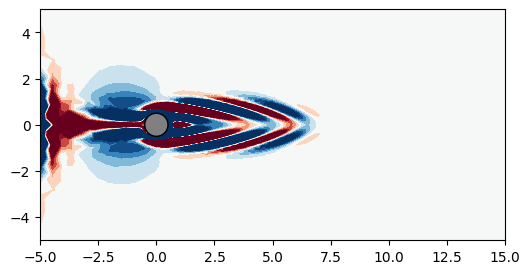

In [10]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [11]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

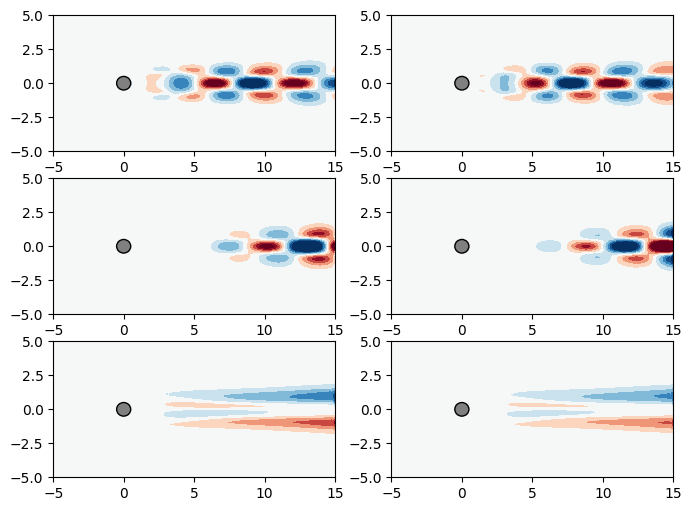

In [12]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

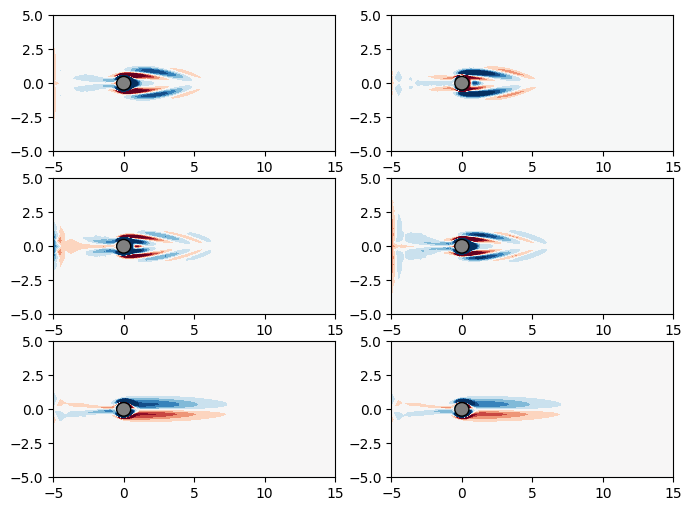

In [13]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

### Natural flow (no actuation)

In [ ]:
data = np.load("re100_open_loop_output/no_actuation.npz")
t = data['t']
u = data['u'][:, None]
xc = data['x']
y = data['y'][:, None]

In [216]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 50
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_nat[i], CD_nat[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}")

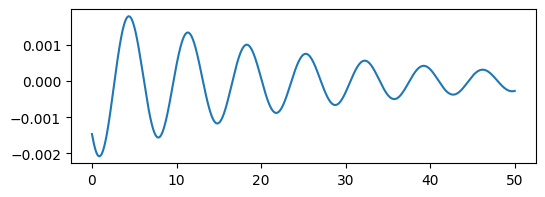

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, y)
plt.show()

### Projection onto global modes

In [16]:
# 4. Projection onto global modes

# r = 9  # Number of global modes for projection
r = len(evals)
print(f"{r=}")
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    # Br[i, 0] = flow.inner_product(qC, W[i])
    Br[i, 0] = flow.inner_product(W[i], qC)
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

r=46


/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


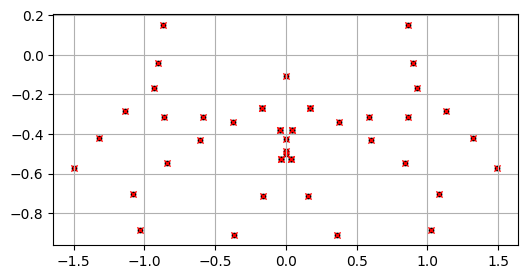

In [17]:
rom_evals = np.linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

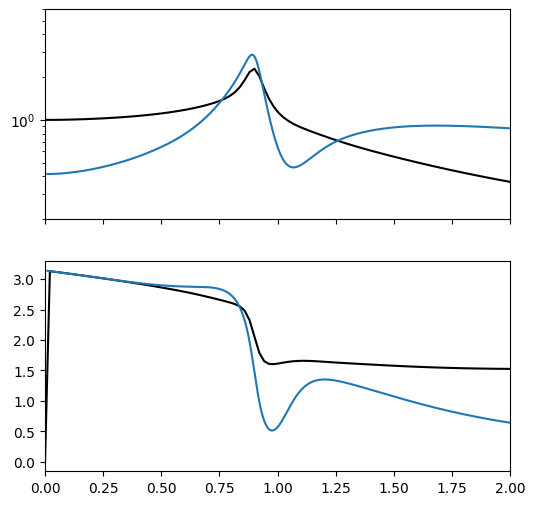

In [18]:
def H(s):
    return Cr @ np.linalg.inv(s * np.eye(r) - Ar) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [161]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # Transformation matrix such that z = T @ x
    T = np.zeros((n, n), dtype=np.cdouble)
    T[di, di] = 1.0
    T[stack_ind + (j, j)] = 0.5j
    T[stack_ind + (j, k)] = 0.5
    T[stack_ind + (k, j)] = -0.5j
    T[stack_ind + (k, k)] = 0.5

    # T = T.conj()

    # FIXME: These transformations have weird negative
    # conjugates and negative signs... kind of suggests
    # something is not right here.

    # Transform the measurement matrix
    Cr = np.real(C.conj() @ T)  # <-- conj??

    # Transform the input matrix
    Br = -np.real(linalg.inv(T.conj()) @ B)

    Dr = D.real

    return Ar, Br, Cr, Dr, T


Ar_real, Br_real, Cr_real, Dr_real, T = real_form(Ar, Br, Cr, Dr)
T_inv = linalg.inv(T)

In [162]:
# Need to be able to project and recover the right observation

q0 = fd.project(ufl.imag(V[1]), fn_space)
# q0 = fd.project(V[1], fn_space)
# q0 = fd.project(0.5 * (V[0] + V[1]), fn_space)
flow.q.assign(q0)
print(flow.get_observations())
# q0.assign(q0 / flow.inner_product(q0, q0))

z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
print(z0[:2])

x0 = T_inv @ z0
print(x0[:2])

print(Cr_real @ x0)

((-0.010504028052849394+0j), (1.6733698399761855e-07+0j))
[-1.11265918e-12+0.5j -1.11265918e-12-0.5j]
[ 1.00000000e+00+0.j -2.22531836e-12+0.j]
[-0.01050403-3.05739799e-13j]


In [21]:
C_hat = Cr_real

q0 = fd.Function(flow.mixed_space).project(ufl.imag(V[0]))
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
# q0 = fd.Function(flow.mixed_space).assign(0.5j * (-V[0] + V[1]))
flow.q.assign(q0)
print(flow.get_observations())
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
print(z0[:2])
x0 = T_inv @ z0
print(x0[:2])
C_hat @ x0

((0.010504028052849394+0j), (-1.6733698399761855e-07+0j))
[1.11265918e-12-0.5j 1.11265918e-12+0.5j]
[-1.00000000e+00+0.j  2.22531836e-12+0.j]


array([0.01050403+3.05739799e-13j])

### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [22]:
complex_rom = False

if complex_rom:
    A_hat, B_hat, C_hat, D_hat = Ar, Br, Cr, Dr
else:
    A_hat, B_hat, C_hat, D_hat = Ar_real, Br_real, Cr_real, Dr_real

In [23]:
ru = 2
m = 1
p = 1

if complex_rom:
    # Low-gain limit
    Q = np.zeros((ru, ru))
    R = np.eye(m)
    P = linalg.solve_continuous_are(A_hat[:ru, :ru], B_hat[:ru], Q, R)

    K = np.zeros_like(B_hat.T)
    Ku = linalg.solve(R, B_hat[:ru].T) @ P
    K[:, :ru] = Ku
    print(Ku)

else:
    # Approximate low-gain limit with large R matrix
    Q = np.eye(r)
    R = 1e8 * np.eye(m)
    K, _, E = control.lqr(A_hat, B_hat, Q, R)
    print(K)
    print(E)

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

[[ 2.17910260e-01 -3.08591633e-02  1.38672261e-06 -6.22161165e-06
  -3.76133996e-12 -3.15580733e-06  1.17908840e-06  4.66070934e-12
  -5.17045624e-11  4.36121336e-11  2.81612034e-11 -3.13033039e-06
  -5.29773857e-07 -4.33070784e-07  1.16057526e-06  2.93396923e-06
   4.51399444e-06  1.77624573e-11 -1.53433110e-10 -2.70436349e-07
  -3.02336347e-07  1.29344525e-07 -3.84464666e-07 -9.72678421e-07
   9.83374048e-07 -3.51758518e-07  1.63813066e-10  6.99657414e-11
  -2.53337073e-07 -2.26318966e-10 -1.88336404e-10 -2.70644634e-10
   2.55004035e-10  2.09035338e-10  2.58583602e-10  2.76327841e-10
   3.64678882e-07  8.24855514e-07 -3.21759167e-09 -9.14943072e-10
   2.09183309e-06 -1.91974239e-06  7.74723963e-08  1.97411488e-07
  -4.94010476e-05  1.47409540e-05]]
[-3.12901346+0.j         -0.5702678 +1.49438658j -0.5702678 -1.49438658j
 -0.42176881+1.32216295j -0.42176881-1.32216295j -0.8850516 +1.02942393j
 -0.8850516 -1.02942393j -0.28606331+1.13358621j -0.28606331-1.13358621j
 -0.70589628+1.0800

(0.1, 10)

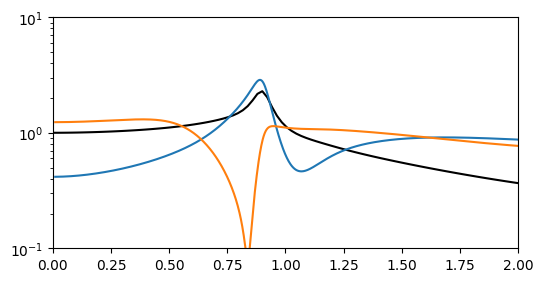

In [24]:
def H_cl(s):
    return C_hat @ np.linalg.inv(s * np.eye(r) - (A_hat + B_hat @ K)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)
ax.set_ylim(0.1, 10)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [24]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50
n_steps = int(tf // dt)
CL_ctrl = np.zeros(n_steps)
CD_ctrl = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    # z = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

    if i > 0:
        # Transform to the real-valued reduced state space
        x[i] = np.real(T_inv @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ z)
        else:
            u[i] = K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        # u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])
        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_ctrl[i], CD_ctrl[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_ctrl[i]:.4f}, CD={CD_ctrl[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0089, CD=0.0000
   u=[-0.06032897], rho=0.0006032896581885781
t=0.02, CL=0.0079, CD=0.0000
   u=[-0.05579152], rho=0.0011612048880247315
t=0.03, CL=0.0069, CD=0.0000
   u=[-0.05065788], rho=0.0016677837148445147
t=0.04, CL=0.0059, CD=0.0000
   u=[-0.04541746], rho=0.002121958354946011
t=0.05, CL=0.0050, CD=0.0000
   u=[-0.04023549], rho=0.0025243132204619606
t=0.06, CL=0.0042, CD=0.0000
   u=[-0.03516589], rho=0.002875972138534601
t=0.07, CL=0.0035, CD=0.0000
   u=[-0.03022448], rho=0.0031782169762519037
t=0.08, CL=0.0029, CD=0.0000
   u=[-0.02541405], rho=0.0034323574969902307
t=0.09, CL=0.0023, CD=0.0000
   u=[-0.020733], rho=0.0036396874961753833
t=0.10, CL=0.0019, CD=-0.0000
   u=[-0.01617831], rho=0.0038014705507448815
t=0.11, CL=0.0015, CD=-0.0000
   u=[-0.01174654], rho=0.003918935916192925
t=0.12, CL=0.0012, CD=-0.0000
   u=[-0.0074342], rho=0.003993277884500665
t=0.13, CL=0.0009, CD=-0.0000
   u=[-0.00323784], rho=0

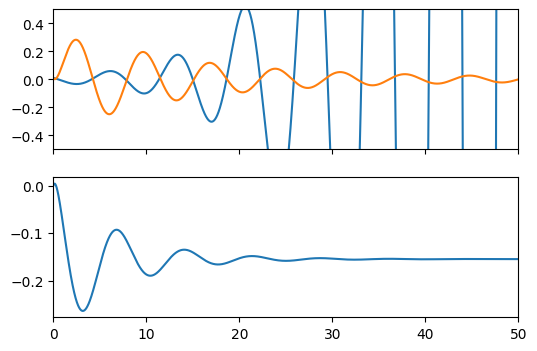

In [25]:
t = np.arange(n_steps) * dt

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].set_ylim([-0.5, 0.5])
# ax[0].plot(t, y)
# ax[1].plot(t, x)
# ax[1].plot(t, u)
ax[1].plot(dt * np.arange(len(rho)), rho)
ax[1].set_xlim([0, 50])
plt.show()


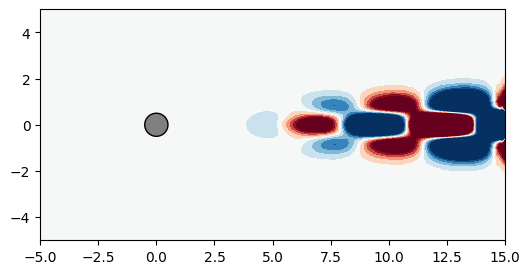

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Boundary condition control

In [27]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis).  We can pre-compute the term
# T @ (W^T @ qC) and subtract it from the full flow field projection at each step

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
xC = np.real(T_inv @ zC)

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
        # z = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

        # Transform to the real-valued reduced state space and offset by
        # the BC value to shift to the corresponding homogeneous solution
        x[i] = np.real(T_inv @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ (z - zC * rho[i-1]))
        else:
            u[i] = K @ (x[i] - xC * rho[i-1])

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0089, CD=0.0000
   u=[-0.06032897], rho=[0.00060329]
t=0.02, CL=0.0082, CD=0.0000
   u=[-0.05513903], rho=[0.00115468]
t=0.03, CL=0.0074, CD=0.0000
   u=[-0.04981729], rho=[0.00165285]
t=0.04, CL=0.0068, CD=-0.0000
   u=[-0.04455212], rho=[0.00209837]
t=0.05, CL=0.0062, CD=-0.0000
   u=[-0.0394032], rho=[0.00249241]
t=0.06, CL=0.0056, CD=-0.0000
   u=[-0.03438745], rho=[0.00283628]
t=0.07, CL=0.0052, CD=-0.0000
   u=[-0.02950766], rho=[0.00313136]
t=0.08, CL=0.0047, CD=-0.0000
   u=[-0.02476203], rho=[0.00337898]
t=0.09, CL=0.0044, CD=-0.0000
   u=[-0.02014729], rho=[0.00358045]
t=0.10, CL=0.0041, CD=-0.0000
   u=[-0.01565978], rho=[0.00373705]
t=0.11, CL=0.0038, CD=-0.0000
   u=[-0.01129579], rho=[0.00385001]
t=0.12, CL=0.0036, CD=-0.0000
   u=[-0.00705169], rho=[0.00392052]
t=0.13, CL=0.0034, CD=-0.0000
   u=[-0.00292394], rho=[0.00394976]
t=0.14, CL=0.0032, CD=-0.0000
   u=[0.0010909], rho=[0.00393885]
t=0.15, CL=0.0031,

t=1.18, CL=0.0812, CD=0.0000
   u=[0.13214509], rho=[-0.09786941]
t=1.19, CL=0.0822, CD=0.0000
   u=[0.13212242], rho=[-0.09919063]
t=1.20, CL=0.0832, CD=0.0000
   u=[0.13208727], rho=[-0.10051151]
t=1.21, CL=0.0842, CD=0.0000
   u=[0.13203977], rho=[-0.10183191]
t=1.22, CL=0.0852, CD=0.0000
   u=[0.13198005], rho=[-0.10315171]
t=1.23, CL=0.0862, CD=0.0000
   u=[0.13190825], rho=[-0.10447079]
t=1.24, CL=0.0872, CD=0.0000
   u=[0.13182448], rho=[-0.10578903]
t=1.25, CL=0.0882, CD=0.0000
   u=[0.13172888], rho=[-0.10710632]
t=1.26, CL=0.0892, CD=0.0000
   u=[0.13162157], rho=[-0.10842254]
t=1.27, CL=0.0902, CD=0.0000
   u=[0.13150266], rho=[-0.10973756]
t=1.28, CL=0.0912, CD=0.0000
   u=[0.13137228], rho=[-0.11105129]
t=1.29, CL=0.0921, CD=0.0000
   u=[0.13123055], rho=[-0.11236359]
t=1.30, CL=0.0931, CD=0.0000
   u=[0.13107758], rho=[-0.11367437]
t=1.31, CL=0.0940, CD=0.0000
   u=[0.13091347], rho=[-0.1149835]
t=1.32, CL=0.0950, CD=0.0000
   u=[0.13073835], rho=[-0.11629089]
t=1.33, CL=

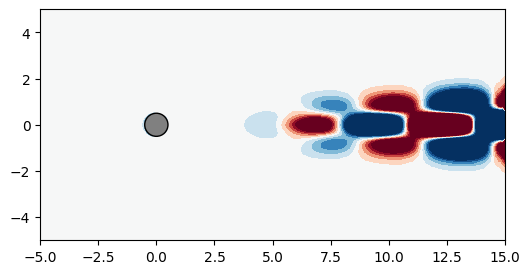

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

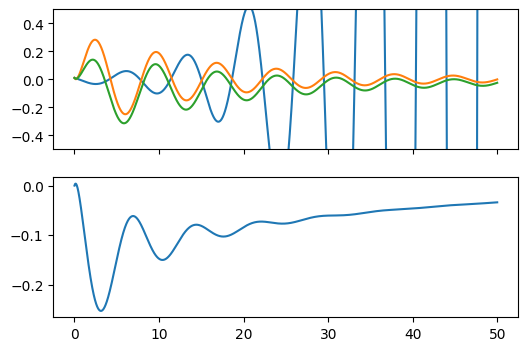

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].plot(dt * np.arange(len(CL_bc)), CL_bc)
ax[0].set_ylim([-0.5, 0.5])

# ax[1].plot(t, CD_ctrl)
# ax[1].plot(t, CD_bc)

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

# NEXT STEPS

* Kalman filter: test estimation while keeping full-state feedback
* LQG: combine Kalman filter with LQR
* BPOD: collect snapshots from direct and adjoint simulations
* Balanced model reduction for stable subspace

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [25]:
# kf_sys = control.ss(A_hat, np.hstack((B_hat, L)), C_hat, np.hstack((D_hat, [0.0])))
# np.hstack((B_hat, L)).shape

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

### No control

In [26]:
C_hat

array([[-1.05040280e-02,  4.86354662e-03, -7.38876873e-04,
        -6.82186338e-04,  6.45040779e-08,  3.44228724e-05,
        -1.69137767e-04, -2.91281255e-09, -5.89181561e-09,
         2.84932846e-09,  5.92279101e-09,  1.19505607e-04,
        -4.14613419e-04,  3.07443283e-05,  1.44332029e-05,
        -1.14558341e-04, -8.43308203e-05,  1.96725466e-08,
        -8.98383123e-09,  1.78347226e-04, -1.22376345e-04,
        -2.12147591e-04, -4.21556906e-05, -5.66818178e-04,
        -6.41625726e-04, -5.35293111e-05,  5.40896802e-09,
         1.02051916e-08,  1.17845030e-04, -1.38648602e-08,
         1.78903945e-08, -8.30891356e-09, -1.49467500e-08,
         1.28724199e-08,  2.26021472e-08, -2.47072463e-08,
        -1.03590002e-03,  4.40884902e-04, -1.29391182e-08,
         4.21268489e-08,  3.35590394e-07,  6.66411559e-06,
         3.25152087e-09,  3.42293627e-09, -9.79791056e-07,
        -5.17313414e-07]])

In [27]:
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
q0 = fd.Function(flow.mixed_space).assign(0.5j * (V[0] - V[1]))
flow.q.assign(q0)
print(flow.get_observations())
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
x0 = np.real(T_inv @ z0)
C_hat @ x0

((-0.010504028045981677+0j), (1.6733791403307258e-07+0j))


array([-0.01050403])

In [28]:
# Kalman filter

if complex_rom:
    L = np.zeros_like(C_hat.T)
    Rf = np.eye(p)
    Pf = linalg.solve_continuous_are(A_hat[:ru, :ru].T.conj(), C_hat[:, :ru].T.conj(), Q, Rf)
    Lu = linalg.solve(Rf, C_hat[:, :ru].conj()) @ Pf
    L[:ru, :] = Lu.T
    print(Lu)

    # Kalman filter (discrete)
    def design_dlqe(A, C):
        Q = np.zeros_like(A)
        R = np.eye(C.shape[0], dtype=C.dtype)
        P = linalg.solve_discrete_are(A.T.conj(), C.T.conj(), Q, R)
        L = linalg.solve(C @ P @ C.T.conj() + R, C @ P @ A.T.conj())
        return L.T.conj()

    L = np.zeros_like(C_hat.T)
    L[:ru, :] = design_dlqe(A_kf[:ru, :ru], C_kf[:, :ru])
    L[:ru]
else:
    Qf = np.eye(r)
    Rf = 1e8 * np.eye(p)
    L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
    L = L.T
    print(L)
    print(np.log(E) / dt)

[[-5.09927173e-01]
 [ 1.40990387e-01]
 [ 6.49680673e-09]
 [ 2.94813092e-09]
 [ 2.79901223e-13]
 [ 1.00166671e-10]
 [-1.21780055e-11]
 [-5.24485067e-15]
 [-8.43941685e-15]
 [ 3.37353625e-15]
 [ 9.38575462e-15]
 [ 3.56504589e-10]
 [-2.42757476e-10]
 [ 2.27149904e-11]
 [ 2.12156449e-11]
 [-6.80950095e-11]
 [-3.56696441e-11]
 [ 1.83113290e-14]
 [-1.32011348e-14]
 [ 1.83092208e-10]
 [-1.20566935e-10]
 [-2.15794898e-10]
 [-3.86222165e-11]
 [-1.70518777e-10]
 [-6.93732955e-10]
 [-4.79607288e-11]
 [ 2.53357332e-15]
 [ 7.22002599e-15]
 [ 9.03146353e-11]
 [-1.01701504e-14]
 [ 1.22928543e-14]
 [-5.61379386e-15]
 [-1.03131977e-14]
 [ 9.06586345e-15]
 [ 1.02572603e-14]
 [ 1.17252926e-14]
 [-7.54313502e-10]
 [ 2.31055337e-11]
 [-5.85346603e-14]
 [ 3.43468339e-14]
 [ 1.12231662e-13]
 [ 3.28952157e-12]
 [-3.93087220e-14]
 [ 3.10123637e-14]
 [-3.31750715e-13]
 [-1.97191761e-13]]
[-0.57019954+1.49442037j -0.57019954-1.49442037j -0.42162937+1.3222185j
 -0.42162937-1.3222185j  -0.28530036+1.13381368j -0.2

In [29]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 10.0
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Kalman filter estimate
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output
u = np.zeros((n_steps, m))  # Control signal

y_proj = np.zeros((n_steps, p))  # Projected measurement

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL, CD = map(np.real, flow.get_observations())
    CL_nat[i], CD_nat[i] = CL, CD

    # Project the flow field onto the reduced basis
    # Note that this will be complex
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    # x[i] = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

    if not complex_rom:
        x[i] = (T_inv @ x[i])

    # Update the Kalman filter estimate 
    y[i] = CL
    y_proj[i] = C_hat @ x[i]
    if i > 0:
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}, y={y[i]}, y_hat={y_hat[i]}, y_proj={y_proj[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)
/tmp/ipykernel_65451/1033053844.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  y_proj[i] = C_hat @ x[i]


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], y=[0.00978918], y_hat=[0.], y_proj=[0.00978918]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.], y=[0.00963618], y_hat=[0.], y_proj=[0.00963618]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.], y=[0.00946944], y_hat=[5.82218468e-05], y_proj=[0.00946944]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.], y=[0.00929729], y_hat=[0.00011525], y_proj=[0.00929729]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.], y=[0.00912251], y_hat=[0.00017106], y_proj=[0.00912251]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.], y=[0.00894603], y_hat=[0.00022563], y_proj=[0.00894603]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.], y=[0.00876817], y_hat=[0.00027895], y_proj=[0.00876817]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.], y=[0.00858905], y_hat=[0.00033101], y_proj=[0.00858905]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.], y=[0.0084087], y_hat=[0.0003818], y_proj=[0.0084087]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.], y=[0.00822714], y_hat=[0.00043132], y_proj=[0.00822714]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.], y=[0

In [30]:
x_rom = np.zeros_like(x)
x_rom[0] = x[0]

for i in range(1, n_steps):
    x_rom[i] = A_kf @ x_rom[i-1]

/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


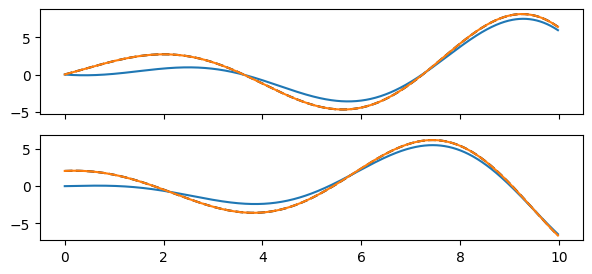

In [31]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
if complex_rom:
    z_plt = z * np.exp(1j * 5*np.pi/4)  # Phase shifted from true state
    ax[0].plot(t, np.real(x[:, 0]), 'k--')
    ax[0].plot(t, np.real(z_plt[:, 0]))
    ax[1].plot(t, np.imag(x[:, 0]), 'k--')
    ax[1].plot(t, np.imag(z_plt[:, 0]))
else:
    ax[0].plot(t, x[:, 0], 'k--')
    ax[0].plot(t, z[:, 0])
    ax[0].plot(t, x_rom[:, 0].real)
    ax[1].plot(t, x[:, 1], 'k--')
    ax[1].plot(t, z[:, 1])
    ax[1].plot(t, x_rom[:, 1].real)
plt.show()

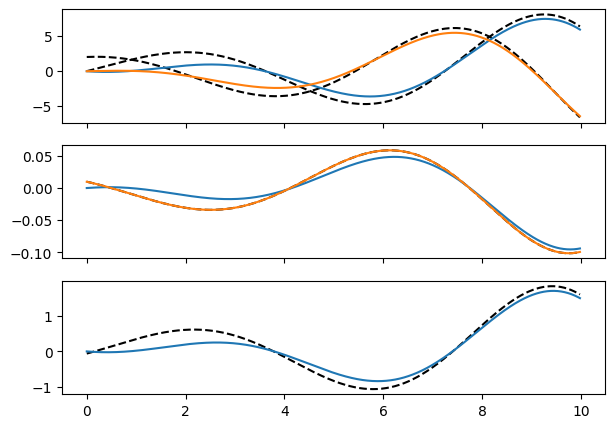

In [32]:

# Transform the measurement matrix


t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, :2]), 'k--')
ax[0].plot(t, np.real(z[:, :2]))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[1].plot(t, x @ C_hat.T)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z @ K.T)
plt.show()

### Kalman filter with forcing

For simplicity, run this with the explicit forcing control (instead of BC control).  This fails, showing that the global modes are not sufficient to construct a model that will capture the input/output behavior

In [197]:
data = np.load("re100_open_loop_output/sine_actuation_ex.npz")
t = data['t']
u = data['u'][:, None]
xc = data['x']
y = data['y'][:, None]
rho = data['rho']

In [198]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # Transformation matrix such that z = T @ x
    T = np.zeros((n, n), dtype=np.cdouble)
    T[di, di] = 1.0
    T[stack_ind + (j, j)] = 0.5j
    T[stack_ind + (j, k)] = 0.5
    T[stack_ind + (k, j)] = -0.5j
    T[stack_ind + (k, k)] = 0.5

    # FIXME: These transformations have weird negative
    # conjugates and negative signs... kind of suggests
    # something is not right here.
    # T = T.conj()

    # Transform the measurement matrix
    Cr = np.real(C @ T.conj())  # <-- conj??

    # Transform the input matrix
    Br = -np.real(linalg.inv(T.conj()) @ B)    # <-- conj??

    Dr = D.real

    return Ar, Br, Cr, Dr, T


A_hat, B_hat, C_hat, D_hat, T = real_form(Ar, Br, Cr, Dr)

T_inv = linalg.inv(T)
x = xc @ T_inv.T

In [199]:
# Need to be able to project and recover the right observation

q0 = fd.project(ufl.imag(V[1]), fn_space)
# q0 = fd.project(V[1], fn_space)
# q0 = fd.project(0.5 * (V[0] + V[1]), fn_space)
flow.q.assign(q0)
print(flow.get_observations())
# q0.assign(q0 / flow.inner_product(q0, q0))

z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
print(z0[:2])

x0 = T_inv @ z0
print(x0[:2])

print(C_hat @ x0)

((-0.010504028052849394+0j), (1.6733698399761855e-07+0j))
[-1.11265918e-12+0.5j -1.11265918e-12-0.5j]
[ 1.00000000e+00+0.j -2.22531836e-12+0.j]
[-0.01050403-3.05739799e-13j]


In [200]:
C_hat[0, :2]

array([-0.01050403,  0.00486355])

In [201]:
# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

# Kalman filter design
Qf = np.eye(r)
Rf = 1e8 * np.eye(p)
L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
L = L.T
# print(L)
# print(np.log(E) / dt)

In [206]:
idx = 1
y[idx]

array([0.0113133])

In [207]:
C_kf @ x[idx].real

array([-0.00784787])

In [208]:
D_kf * u[idx]

array([0.5936576])

/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


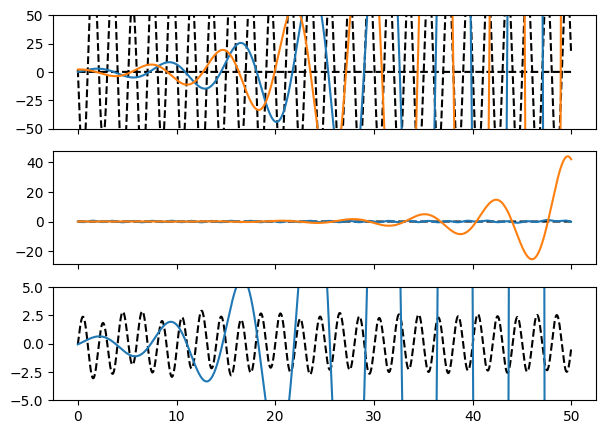

In [218]:
n_steps = len(t)
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

for i in range(n_steps):

    y_est = 0.0
    if i > 0:
        # Estimate using true projection.. this should match y[i] reasonably well
        # provided the ROM is a good approximation
        y_est = np.real(C_kf @ x[i-1] + D_kf * u[i-1])

        y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
        z[i] = A_kf @ z[i-1] - B_kf @ u[i-1] + L @ (y[i] - y_hat[i])
    
        # z[i] = A_kf @ z[i-1] - B_kf @ u[i-1]

    else:
        z[i] = x[i]

fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, :2]), 'k--')
ax[0].plot(t, np.real(z[:, :2].conj()))
ax[0].set_ylim([-50, 50])
ax[1].plot(t, y, 'k--')
ax[1].plot(t, x @ C_kf.T + D_kf * u)
ax[1].plot(t, y_hat)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z @ K.T)
ax[2].set_ylim([-5, 5])
plt.show()

In [196]:
B_kf.shape

(46, 1)